This notebook presents how to train ARedsum models, the extractive summarization based models, on ThaiSum dataset.

# Introduction to ARedSumSentRank
Cite from their paper's abstract ["AREDSUM: Adaptive Redundancy-Aware Iterative Sentence Ranking for Extractive Document Summarization"](https://arxiv.org/abs/2004.06176) introduced by Keping Bi, Rahul Jha, W. Bruce Croft, Asli Celikyilmaz. (2020), 
"...Building on the state-of-the-art encoding methods for summarization, we present two adaptive learning models: AREDSUM-SEQ that jointly considers salience and novelty during sentence selection; and a two-step AREDSUM-CTX that scores salience first, then learns to balance salience and redundancy, enabling the measurement of the impact of each aspect...."

# Install requirements 

In [2]:
%%capture
!git clone https://github.com/nakhunchumpolsathien/ThaiSum.git

In [3]:
%%capture 
!pip install torch==1.1.0 torchvision==0.3.0
!pip install -q pyrouge
!pip install -q pytorch_transformers
!pip install -q tensorboardX
!pip install -q pyrouge
!pip install pytorch_pretrained_bert
!pyrouge_set_rouge_path "/content/ThaiSum/BertSum/ROUGE-1.5.5"
!apt update
!apt install -q libxml-parser-perl
%cd "/content/ThaiSum/BertSum/ROUGE-1.5.5/data"
!perl WordNet-2.0-Exceptions/buildExeptionDB.pl ./WordNet-2.0-Exceptions ./smart_common_words.txt ./WordNet-2.0.exc.db

# Pre-processing

In [5]:
%cd '/content/ThaiSum/ARedSum/src'
!python preprocess.py -mode format_to_bert -raw_path "/content/ThaiSum/ARedSum/js_data" -save_path "/content/ThaiSum/ARedSum/bert_data" -oracle_mode greedy -n_cpus 1 -log_file ../logs/preprocess.log

/content/ThaiSum/ARedSum/src
[2020-11-14 08:14:51,896 INFO] https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-multilingual-cased-vocab.txt not found in cache, downloading to /tmp/tmpl3nov12u
100% 995526/995526 [00:00<00:00, 5627327.20B/s]
[2020-11-14 08:14:52,225 INFO] copying /tmp/tmpl3nov12u to cache at /root/.pytorch_pretrained_bert/96435fa287fbf7e469185f1062386e05a075cadbf6838b74da22bf64b080bc32.99bcd55fc66f4f3360bc49ba472b940b8dcf223ea6a345deb969d607ca900729
[2020-11-14 08:14:52,227 INFO] creating metadata file for /root/.pytorch_pretrained_bert/96435fa287fbf7e469185f1062386e05a075cadbf6838b74da22bf64b080bc32.99bcd55fc66f4f3360bc49ba472b940b8dcf223ea6a345deb969d607ca900729
[2020-11-14 08:14:52,227 INFO] removing temp file /tmp/tmpl3nov12u
[2020-11-14 08:14:52,228 INFO] loading vocabulary file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-multilingual-cased-vocab.txt from cache at /root/.pytorch_pretrained_bert/96435fa287fbf7e469185f1062386e05a075cadbf68

# Training the model

In [7]:
# Train (ARedSum-Base) Train a Salience Ranker
!python train.py -bert_data_path "/content/ThaiSum/ARedSum/bert_data/thaisum" -visible_gpus 0 -gpu_ranks 0 -accum_count 2 -report_every 50 -save_checkpoint_steps 2000 -decay_method noam -mode train -model_name base -label_format soft -result_path "/content/ThaiSum/ARedSum/results/aredsum_base" -model_path "/content/ThaiSum/ARedSum/model_checkpoint/ARedSum_base"

[2020-11-14 08:21:49,629 INFO] Device ID 0
[2020-11-14 08:21:49,629 INFO] Device cuda
[2020-11-14 08:21:49,802 INFO] loading archive file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-multilingual-cased.tar.gz from cache at ../temp/731c19ddf94e294e00ec1ba9a930c69cc2a0fd489b25d3d691373fae4c0986bd.4e367b0d0155d801930846bb6ed98f8a7c23e0ded37888b29caa37009a40c7b9
[2020-11-14 08:21:49,803 INFO] extracting archive file ../temp/731c19ddf94e294e00ec1ba9a930c69cc2a0fd489b25d3d691373fae4c0986bd.4e367b0d0155d801930846bb6ed98f8a7c23e0ded37888b29caa37009a40c7b9 to temp dir /tmp/tmplzetjsc0
[2020-11-14 08:21:56,188 INFO] Model config {
  "attention_probs_dropout_prob": 0.1,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "max_position_embeddings": 512,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  

In [ ]:
# Train (ARedSum-CTX) Train a Ranker for Selection
!python train.py -fix_scorer -train_from /path/to/the/best/salience/ranker.pt -bert_data_path /path/to/cnndm_or_nyt50/bert_data/ -visible_gpus 2 -gpu_ranks 0 -accum_count 2 -report_every 50 -save_checkpoint_steps 2000 -decay_method noam -model_name ctx -max_epoch 2 -train_steps 50000 -label_format soft -use_rouge_label t -valid_by_rouge t -rand_input_thre 1.0 -temperature 20 -seg_count 30 -ngram_seg_count 20,20,20 -bilinear_out 20 -result_path /path/to/where/you/want/to/save/the/preidicted/summaries -model_path /path/to/where/you/want/to/save/the/models

In [ ]:
# Train (ARedSum-SEQ) Train a Sequence Generation Model
!python train.py -bert_data_path /path/to/cnndm_or_nyt50/bert_data/ -visible_gpus 2 -gpu_ranks 0 -accum_count 2 -report_every 50 -save_checkpoint_steps 2000 -decay_method noam -model_name seq -max_epoch 2 -train_steps 50000 -label_format soft -use_rouge_label t -valid_by_rouge t -rand_input_thre 0.8 -temperature 20 -result_path /path/to/where/you/want/to/save/the/preidicted/summaries -model_path /path/to/where/you/want/to/save/the/models

# Evaluation

## Evaluate by ROUGE Score 

In [11]:
# Evaluate ARedSum-Base 
!python train.py -bert_data_path "/content/ThaiSum/ARedSum/bert_data/thaisum" -visible_gpus 0 -gpu_ranks 0 -accum_count 2 -report_every 50 -save_checkpoint_steps 2000 -decay_method noam -mode test -model_name base -label_format soft -result_path "/content/ThaiSum/ARedSum/results/aredsum_base" -test_from "/content/ThaiSum/ARedSum/model_checkpoint/ARedSum_base.pt"

[2020-11-14 08:30:40,819 INFO] Loading checkpoint from /content/ThaiSum/ARedSum/model_checkpoint/ARedSum_base.pt
Namespace(accum_count=2, aggr='last', batch_size=3000, bert_config_path='config/bert_config_uncased_base.json', bert_data_path='/content/ThaiSum/ARedSum/bert_data/thaisum', beta1=0.9, beta2=0.999, bilinear_out=10, block_trigram=True, dataset='', decay_method='noam', dropout=0.1, ff_size=2048, fix_scorer=False, gpu_ranks=[0], heads=8, hidden_size=128, inter_layers=2, label_format='soft', log_file='../logs/cnndm.log', loss='wsoftmax', lr=0.002, max_epoch=2, max_grad_norm=0, max_label_sent_count=3, mode='test', model_name='base', model_path='../models/', ngram_seg_count='20,20,20', optim='adam', param_init=0, param_init_glorot=True, rand_input_thre=1.0, recall_eval=False, report_every=50, report_precision=True, report_rouge=True, result_path='/content/ThaiSum/ARedSum/results/aredsum_base', rnn_size=512, salience_softmax=False, save_checkpoint_steps=2000, save_model_count=3, see


ROUGE Scores are shown here
```
[2020-11-14 08:31:40,328 INFO] [PERF]Rouges at step 0: RG1-P:42.77	RG1-R:56.72	RG1-F:45.16	RG2-P:20.05	RG2-R:29.11	RG2-F:21.83	RGL-P:42.71	RGL-R:56.59	RGL-F:45.08 
```
Therefore ROUGE-F1 results are:  R1=45.16, R2=21.83, RL=45.08.



## Evaluate by BertScore

In [2]:
!pip install -q bert_score
import bert_score
from bert_score import score
import logging
import transformers
transformers.tokenization_utils.logger.setLevel(logging.ERROR)
transformers.configuration_utils.logger.setLevel(logging.ERROR)
transformers.modeling_utils.logger.setLevel(logging.ERROR)

In [3]:
with open("/content/ThaiSum/ARedSum/results/aredsum_base_step0_initial.candidate") as f: # Output Summary 
    cands = [line.strip() for line in f]

with open("/content/ThaiSum/ARedSum/results/aredsum_base_step0_initial.gold") as f:  # Reference Summary
    refs = [line.strip() for line in f]

In [4]:
P, R, F1 = score(cands, refs, lang='th', verbose=False)

print(f"System level F1 score: {F1.mean()*100:.3f}") ##  *100 to make it simplier to read similar to ROUGE.
print(f"System level P score: {P.mean()*100:.3f}")
print(f"System level R score: {R.mean()*100:.3f}")

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1423: FutureWarning: The `max_len` attribute has been deprecated and will be removed in a future version, use `model_max_length` instead.
  FutureWarning,


System level F1 score: 81.076
System level P score: 79.806
System level R score: 82.700


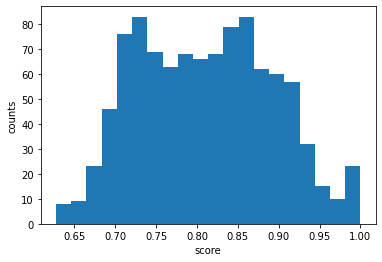

In [5]:
import matplotlib.pyplot as plt
plt.hist(F1, bins=20)
plt.xlabel("score")
plt.ylabel("counts")
plt.show()